<a href="https://colab.research.google.com/github/kmkarakaya/ML_tutorials/blob/master/seq2seq_Part_E_Encoder_Decoder_for_Variable_Input_And_Output_Sizes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PART E: Encoder Decoder for Variable Input And Output Sizes
Welcome to the **Part E** of Seq2Seq Learning Tutorial Series.
In this tutorial, we will design an Encoder Decoder model to handle **Variable** Input And Output sequence sizes by using **Padding** and **Masking**.

We will use the **LSTM** layer in Keras as the Recurrent Neural Network.

If you would like to follow up all the tutorials, please **subcribe** to [my YouTube Channel](https://www.youtube.com/channel/UCrCxCxTFL2ytaDrDYrN4_eA/playlists) or **follow** [my blog on Medium](https://medium.com/@kmkarakaya). Do not forget to turn on **Notifications** so that you will be notified when ***new parts are uploaded***.

You can access this **Colab Notebook** using [the link](https://colab.research.google.com/drive/1cxDOWY7PQSx-tRy8inE2IG7-xGpVJWNP?usp=sharing) given in the video descriptions below.

If you are ready, let's get started!


___
# References:



**Blogs**:

* [Tensorflow/Keras Masking Padding official website](https://www.tensorflow.org/guide/keras/masking_and_padding)

* [Tensorflow/Keras LSTM official website](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)

* [A ten-minute introduction to sequence-to-sequence learning in Keras by Francois Chollet](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html)

* [How to Develop an Encoder-Decoder Model with Attention in Keras by Jason Brownlee](https://machinelearningmastery.com/encoder-decoder-attention-sequence-to-sequence-prediction-keras/)

**Presentations:**

* [LSTM from a programmer's perspective by Murat Karakaya Akademi](https://github.com/kmkarakaya/ML_tutorials/raw/bf15d1d5aebd23e05420c12f3c954abea9204b1f/ppt/HOW%20KERAS%20LSTM%20WORKS.pptx)

**Videos:**
* [LSTM from scratch by Murat Karakaya Akademi](https://youtu.be/7nnSjZBJVDs)

**Notebooks**:
* [LSTM intro by Murat Karakaya Akademi](https://colab.research.google.com/drive/1kG5pUczEtqdDtMHiNL-mvgTi-5-Y058t?usp=sharing)
* [Recap LSTM outputs by Murat Karakaya Akademi](https://colab.research.google.com/drive/1nUazJkXcRZi-XiXCr6sEgCy2Z5Mhze1n?usp=sharing)



---
# Import Dependencies & Auxiliary Functions

In [ ]:
#@title Check GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

GPU device not found
time: 2.67 ms


In [ ]:
#@title Version Info
print('tf version: ', tf.__version__)
print('tf.keras version:', tf.keras.__version__)


tf version:  2.3.0
tf.keras version: 2.4.0
time: 6.53 ms


In [ ]:
#@title Time
!pip install ipython-autotime

%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.35 s


In [ ]:
#@title Import Libraries
from random import randint
from numpy import array
from numpy import argmax
import keras.backend as K
from tensorflow.keras import models
from numpy import array_equal
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Input
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K

tf.keras.backend.set_floatx('float64')

time: 9.45 ms


In [ ]:
#@title Functions to generate Seq2Seq Dataset, one hot encode / decode Input & Output Sequences


# generate a sequence of random integers
def generate_sequence(min_timesteps_in, max_timesteps_in, n_unique):
	return [randint(1, n_unique-1) for _ in 
	        range( randint(min_timesteps_in, max_timesteps_in))]

# one hot encode sequence
def one_hot_encode(sequence, n_unique):
	encoding = list()
	
	for value in sequence:
		vector = [0 for _ in range(n_unique)]
		vector[value] = 1
		encoding.append(vector)
	return array(encoding)

# decode a one hot encoded string
def one_hot_decode(encoded_seq):
	return [argmax(vector) for vector in encoded_seq]

# prepare data for the LSTM
def get_reversed_pairs(min_timesteps_in, max_timesteps_in,vocabulary_size,verbose= False):
	# generate random sequence
	sequence_in = generate_sequence(min_timesteps_in, max_timesteps_in, vocabulary_size)
	sequence_out = sequence_in[::-1]
	sequence_out =[i for i in sequence_out if i%2 ==0 and i != 0]
	
	# one hot encode
	X = one_hot_encode(sequence_in, vocabulary_size)
	y = one_hot_encode(sequence_out, vocabulary_size)

	return X,y


def create_dataset(train_size, test_size, 
                   min_timesteps_in, max_timesteps_in, vocabulary_size, verbose= False):
	pairs = [get_reversed_pairs(min_timesteps_in, max_timesteps_in,vocabulary_size) for _ in range(train_size)]
	
	pairs=np.array(pairs).squeeze()
	X_train = pairs[:,0]
	y_train = pairs[:,1]
	pairs = [get_reversed_pairs(min_timesteps_in, max_timesteps_in,vocabulary_size) for _ in range(test_size)]
	pairs=np.array(pairs).squeeze()
	X_test = pairs[:,0]
	y_test = pairs[:,1]	

	if(verbose):
  
		print('\nSample X and y sequences')
		for i in range(5):
			print('X[',i,']=%s' % (one_hot_decode(X_train[i])), '........ y[',i,']=%s' % (one_hot_decode(y_train[i])))

		print('\nEach input and output sequences are converted one_hot_encoded format with input_dimension = ',
		      vocabulary_size)
		print('X[0]=\n%s' % (X_train[0]))
		print('y[0]=\n%s' % (y_train[0]))
	
		print('\nGenerated sequence datasets as follows [sample_size,time_steps, input_dimension]')
		print('X_train.shape: ', X_train.shape,'y_train.shape: ', y_train.shape)
		print('X_test.shape: ', X_test.shape,'y_test.shape: ', y_test.shape)
	
	return X_train, y_train, X_test, 	y_test

time: 51.2 ms


In [ ]:
#@title Function to Train & Test  given model (Early Stopping monitor 'val_loss')
def train_test(model, X_train, y_train , X_test, 	y_test, epochs=500, batch_size=32, patience=5,verbose=0):
	# patient early stopping
	#es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1, patience=20)
	es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
	# train model
	print('training for ',epochs,' epochs begins with EarlyStopping(monitor= val_loss, patience=',patience,')....')
	history=model.fit(X_train, y_train, validation_split= 0.1, epochs=epochs,batch_size=batch_size, verbose=verbose, callbacks=[es])
	print(epochs,' epoch training finished...')

	# report training
	# list all data in history
	#print(history.history.keys())
	# evaluate the model
	_, train_acc = model.evaluate(X_train, y_train, batch_size=batch_size, verbose=0)
	_, test_acc = model.evaluate(X_test, 	y_test, batch_size=batch_size, verbose=0)
	print('\nPREDICTION ACCURACY (%):')
	print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))
	# summarize history for accuracy
	plt.plot(history.history['accuracy'])
	plt.plot(history.history['val_accuracy'])
	plt.title(model.name+' accuracy')
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()
	# summarize history for loss
	plt.plot(history.history['loss'])
	plt.plot(history.history['val_loss'])
	plt.title(model.name+' loss')
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()

  
	# spot check some examples
	space = 3*len(one_hot_decode(y_test[0]))
	print('10 examples from test data...')
	print('Input',' '*(space-4) ,'Expected',' '*(space-7) ,
	      'Predicted',' '*(space-5) ,'T/F')
	correct =0 
	sampleNo =  10

	predicted= model_encoder_decoder.predict(X_test[:sampleNo], batch_size=batch_size)
	for sample in range(0,sampleNo):
		if (one_hot_decode(y_test[sample])== one_hot_decode(predicted[sample])):
			correct+=1
		print( one_hot_decode(X_test[sample]), ' ', 
					one_hot_decode(y_test[sample]),' ', one_hot_decode(predicted[sample]),
					' ',one_hot_decode(y_test[sample])== one_hot_decode(predicted[sample]))
	print('Accuracy: ', correct/sampleNo)
	
	return model_encoder_decoder

time: 48 ms


---
# SEQ2SEQ LEARNING SERIES:
* This is the **Part E** of the Seq2Seq Learning series.

* **Please check out the previous parts** to ***refresh*** the necessary background knowledge in order to follow this part with ease.

You can access all my **SEQ2SEQ Learning** videos on **[Murat Karakaya Akademi Youtube channel](https://www.youtube.com/channel/UCrCxCxTFL2ytaDrDYrN4_eA/playlists?view=1&flow=grid)** in [ENGLISH](https://www.youtube.com/playlist?list=PLQflnv_s49v-4aH-xFcTykTpcyWSY4Tww) or in [TURKISH](https://www.youtube.com/playlist?list=PLQflnv_s49v97hDXtCo4mgje_SEiJ0_hH)

You can access to [my blog on Medium](https://medium.com/@kmkarakaya)

**Part A: AN INTRODUCTION TO SEQ2SEQ LEARNING AND A SAMPLE SOLUTION WITH MLP NETWORK** 
 
   * YouTube Videos in [ENGLISH](https://youtu.be/9TEPkRLhgSc) or [TURKISH](https://youtu.be/p2QlkuV4ito) / [Medium Post](https://medium.com/@kmkarakaya/part-a-introduction-to-seq2seq-learning-a-sample-solution-with-mlp-network-95dc0bcb9c83?sk=2063e3c62b1989efedf6625ac626c2ee) / [Colab Notebook](https://colab.research.google.com/drive/1fffqeeJsY89LuxsEl_7Re33nCWGusjCj?usp=sharing)

**Part B: SEQ2SEQ LEARNING WITH RECURRENT NEURAL NETWORKS (LSTM)** 

   * YouTube Video in [ENGLISH](https://youtu.be/7L5bkMu0Pgg) or [TURKISH](https://youtu.be/UA4rDcq5Cuo) / [Medium Post](https://medium.com/@kmkarakaya/seq2seq-part-b-using-lstm-layer-in-a-recurrent-neural-network-9be629bb71e2?source=friends_link&sk=0b6e0f34592100b991664c55061ca394) / [Colab Notebook](https://colab.research.google.com/drive/1DBaHgsoPJCoj8SXAqNqQtKqAtwrUc4qS?usp=sharing)


**Part C: SEQ2SEQ LEARNING WITH A BASIC ENCODER DECODER MODEL** 

   * YouTube Video in [ENGLISH](https://youtu.be/iHJkfsV9cqY) or [TURKISH](https://youtu.be/SZNqENbc9f4)/ [Medium Post](https://medium.com/@kmkarakaya/seq2seq-part-c-basic-encoder-decoder-a7f536f5f510) / [Colab Notebook](https://colab.research.google.com/drive/1ErnVEZOmlu_nInxaoLStW0BHzgT4meVj?usp=sharing)

**Part D: SEQ2SEQ LEARNING WITH AN ENCODER DECODER MODEL + TEACHER FORCING** 

   * YouTube Video in [ENGLISH](https://youtu.be/RRP0czWtOeM) or [TURKISH](https://youtu.be/JVIiPaCFB78) / [Medium Post](https://medium.com/@kmkarakaya/seq2seq-part-d-encoder-decoder-with-teacher-forcing-18a3a09a096) / [Colab Notebook](https://colab.research.google.com/drive/1TNUB8vsZimVZl_wktWS1ac4wyw8kaNLW?usp=sharing)

**Part E: SEQ2SEQ LEARNING WITH AN ENCODER DECODER MODEL FOR VARIABLE INPUT AND OUTPUT SIZE** 

   * YouTube Video / Medium Post / [Colab Notebook](https://colab.research.google.com/drive/1DtOpSacgqJ1hDQ3GSx0BZgnQHrjwJAsy?usp=sharing)

**Part F: SEQ2SEQ LEARNING WITH AN ENCODER DECODER MODEL + TEACHER FORCING FOR VARIABLE INPUT AND OUTPUT SIZE** 

   * YouTube Video / Medium Post / [Colab Notebook](https://colab.research.google.com/drive/1cxDOWY7PQSx-tRy8inE2IG7-xGpVJWNP?usp=sharing)

**Part G: SEQ2SEQ LEARNING WITH AN ENCODER DECODER MODEL + BAHDANAU ATTENTION** 

   * YouTube Video / Medium Post / [Colab Notebook](https://colab.research.google.com/drive/1VFfeP3eiauYCRvW8vMvL0NRKaOtcGz3J?usp=sharing)


**Part H: SEQ2SEQ LEARNING WITH AN ENCODER DECODER MODEL + LUONG ATTENTION** 

   * YouTube Video / Medium Post / [Colab Notebook](https://colab.research.google.com/drive/1N0ycXm7Lq3jWzbJERRy6rwL1Ux4hmlWM?usp=sharing)


---
# WHY WE HAVE SO MANY PARTS?
* Our aim is to code an Encoder Decoder Model with Attention. 
* However, I would like to develop the solution by showing the shortcomings of other possible approaches.
* Therefore, in the first 2 parts, we will observe that initial models have their own weakness.
* We also understand why Encoder Decoder paradigm is so successful.

**So, please patiently follow the parts as we develop a better solution :)**

---
# A Simple Seq2Seq Problem: The reversed sequence problem
Assume that:
* We are given a **parallel data set** including X (input) and y (output) such that X[i] and y[i] have ***some*** relationship.

In real life (like *Machine Language Translation, Image Captioning*, etc.), we are ***given*** (or ***build***) a **parallel dataset**: **X** sequences and corresponding **y** sequences

* However, to set up an ***easily traceable*** example, I opt out to prepare a rather simple sequence learning problem.

* We use the **parallel data sets** to train a **seq2seq** model which would learn 

  * how to **convert/transform an input sequence from X 
to an output sequence in y**

* For instance: we are given the **same book's text** in English (X) and in Turkish (y). Thus the **statement X[i]** in English is translated into Turkish as **y[i] statement**. We use these parallel date sets to train a **seq2seq** model which would learn how to **convert/transform X[i] to y[i]**

In this part, we will develop such an encoder-decoder model for **variable-size** input and output sequences

* Consider two parallel sequence datasets **X** and **y** as below:

 X[0]=[3, 2, 9, 4]..................................y[0]=[4, 2]

 X[1]=[7, 6, 5, 2, 5, 2].......................... y[1]=[2, 2, 6]

 X[2]=[1, 7, 5, 1, 3]...............................y[2]=[]

 **NOTICE THAT** input (X) and output (y) sequences have **variable lengths** 

* Actually, for this simple Seq2Seq Learning problem,  we formulate the **y** sequence as **the even numbers  of the given sequence (X) in reverse order**. 
* **Assume** that you do not know that relation: You only have 2 parallel datasets X and y

* To create parallel datasets X and y, I already prepare a function and an interface to configure it as below

**IMPORTANT**: I **reserve 0 (zero)** as a **special symbol** and therefore I do **NOT use** it in sequences as a number!







In [ ]:
#@title Configure problem

min_timesteps_in =   4#@param {type:"integer"}
max_timesteps_in =   4#@param {type:"integer"}

input_dimension = 10   #@param {type:"integer"}
#each value is one_hot_encoded with 10 0/1


# generate random sequence
X,y = get_reversed_pairs(min_timesteps_in, max_timesteps_in,  input_dimension, verbose=True)
# generate datasets
train_size= 4000 #@param {type:"integer"}
test_size = 200  #@param {type:"integer"}

X_train, y_train , X_test, 	y_test=create_dataset(train_size, test_size, min_timesteps_in, max_timesteps_in, input_dimension , verbose=True)




Sample X and y sequences
X[ 0 ]=[3, 9, 7, 5] ........ y[ 0 ]=[]
X[ 1 ]=[8, 3, 4, 7] ........ y[ 1 ]=[4, 8]
X[ 2 ]=[7, 4, 9, 8] ........ y[ 2 ]=[8, 4]
X[ 3 ]=[4, 5, 5, 1] ........ y[ 3 ]=[4]
X[ 4 ]=[8, 2, 2, 7] ........ y[ 4 ]=[2, 2, 8]

Each input and output sequences are converted one_hot_encoded format with input_dimension =  10
X[0]=
[[0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0 0 0]]
y[0]=
[]

Generated sequence datasets as follows [sample_size,time_steps, input_dimension]
X_train.shape:  (4000,) y_train.shape:  (4000,)
X_test.shape:  (200,) y_test.shape:  (200,)
time: 102 ms


**Important**: Pay attention to **shapes** of X and y  data sets. Even though we created 3D arrays [***sample_size,time_steps, input_dimension***], we observed above that Python reports their corresponding shapes as (**4000,**) or (**200,**). Why? Because, other than the sample_size dimension, other dimensions do NOT have a **fixed** size! *time_steps* and *input_dimension* have **variable** sizes! Therefore, Python can NOT print their shapes.

---
# How to handle variable Input and Output sequence size
* In our previous posts, we  **assumed** that input and output sequence sizes are **fixed, known in advance**
* Now, we relax this requirement by assuming **input & output sequence sizes may vary**
* However, in Artificial Neural Network models (including encoder decoder models), the first and last layers have **fixed number of neurons** and ***during training***, we need to provide **fixed-size samples** in input and output data sets.  
* Therefore, ANN models should be trained with samples structured in a fixed-size shape.
* However, since we have variable-size input/output samples, we need to convert them into a a fixed-size shape.
* The popular solution has two parts:
  * **During training**: we will use **padding** and **masking** to make  sample sequence sizes equal.
  * **During inference**: For variable ouput sequence size, we will modify the decoder such that it will work in a loop and stop generating output when a **condition is met**.

Don't worry, we will implement the above solution step by step. 

So let's get stated!



---
#Padding
* **Padding** means **appending a special symbol** to the *beginning* or *ending* of a sequence
* The special symbol is mostly 0 (for example in Conv NN) but ***can be any symbol which is not used as a value in the sequences***
* We will use padding to **extend** the given sequence to a specific size
* Assume we are given the sequence [4, 6, 8], we can pad ***two*** 0 (zeros) in two different ways:
  * **post-padding:** We append the padding **in the end of** the sequence such that resulting sequence becomes [4, 6, 8, 0, 0] and **its size is now 5 instead of 3**!
  * **pre-padding:** We can also append the padding **to the beggining of** the sequence: [0, 0, 4, 6, 8]

* **Notice that:** Even the original information ([4, 6, 8]) is reserved, the **size of the padded sequence** ([4, 6, 8, 0, 0] or [0, 0, 4, 6, 8] ) is **changed/incremented**

* **Important:** Tensorflow/Keras **recommends** using "**post**" padding when working with RNN layers in order to be able to use the ***CuDNN*** implementation of the layers. THus, we will use post-padding in this tutorial.

## How to use padding in variable-size input/output sequences?

* First we will find out the **maximum number of time steps** in input/output data set
* Then, we will append **necessary number** of paddings to the end of each sequence such that their number of time steps will be equal to the maximum number of time steps in the data set. 
* In the end, all the input/output sequences will have the **same** number of time steps

## What would be the effect of padding in training & testing
* Remember that we had reserved 0 (zero) when we create the X and y datasets
* We reserved 0 (zero) for padding
* In training 
  * the input layer will consume all the sequence and the paddings 
  * the ouput layer will learn to produce 0 (zero) when the output sequence finishes 
* In testing
  * the input layer will consume all the sequence and the paddings
  * the ouput layer will stop to predicting when it generates 0 (zero) as output  

---
## Let's apply padings to input/output sequences



First we will find out the **maximum** sequence size for input/output sequences in Train data set:

In [ ]:
max_input_sequence= max(len(seq) for seq in X_train)
print('max_input_sequence: ', max_input_sequence)

max_output_sequence= max(len(seq) for seq in y_train)
print('max_output_sequence: ', max_output_sequence)

max_input_sequence:  4
max_output_sequence:  4
time: 8.16 ms


In this example, `max_input_sequence` and `max_ouput_sequence` are **equal** but they could be different for your datasets. The point is you need to handle input and output sequences **separately**!

Then, we will append **necessary number** of paddings to the end of each input sequence such that their number of time steps will be equal to the maximum number of time steps in the data set.

We can use `pad_sequences()` function from Keras preprocessing library as below.

**Note that**: if the `maxlen` argument is NOT provided, function automatically sets `maxlen` to the maximum sequence size in the samples. Therefore, actually, I will not provide `max_input_sequence` and `max_ouput_sequence` to the `pad_sequences()` function. 

`pad_sequences(sequences, maxlen=None, dtype='int32', padding='pre', truncating='pre', value=0.0)`

In [ ]:
from keras.preprocessing.sequence import pad_sequences
X_train_padded = pad_sequences(X_train, maxlen= max_input_sequence, padding='post')
print("X_train shape: ",X_train.shape)
print("X_train_padded shape: ",X_train_padded.shape)

y_train_padded = pad_sequences(y_train, maxlen= max_output_sequence, padding='post')
print("y_train shape: ",y_train.shape)
print("y_train_padded shape: ",y_train_padded.shape)

X_train shape:  (4000,)
X_train_padded shape:  (4000, 4, 10)
y_train shape:  (4000,)
y_train_padded shape:  (4000, 4, 10)
time: 40.4 ms


**Notice that** after padding, each sequence in X_train_padded has the same shape: (4000, **8, 10**): 8 time steps with 10-dimension representation! That is, we have **fixed-size** input data set!

Let's see an example input before  and after padding:

In [ ]:
i=0
print("____Sample Input____")
print("Original:\n", one_hot_decode(X_train[i]))
print("Padded:\n",one_hot_decode(X_train_padded[i]))
print("____Corresponding Output____")
print("Original:\n", one_hot_decode(y_train[i]))
print("Padded:\n",one_hot_decode(y_train_padded[i]))

____Sample Input____
Original:
 [3, 9, 7, 5]
Padded:
 [3, 9, 7, 5]
____Corresponding Output____
Original:
 []
Padded:
 [0, 0, 0, 0]
time: 5.61 ms


Let's apply padding to Test data set as well

In [ ]:
X_test_padded = pad_sequences(X_test, maxlen= max_input_sequence, padding='post')
print("X_test shape: ",X_test.shape)
print("X_test_padded shape: ",X_test_padded.shape)

y_test_padded = pad_sequences(y_test, maxlen= max_output_sequence, padding='post')
print("y_test shape: ",y_test.shape)
print("y_test_padded shape: ",y_test_padded.shape)

X_test shape:  (200,)
X_test_padded shape:  (200, 4, 10)
y_test shape:  (200,)
y_test_padded shape:  (200, 4, 10)
time: 12.6 ms


# Masking

* **Masking** is a way to tell ***sequence-processing layers*** that certain timesteps in an input are missing, and thus should be skipped when processing the data.
* Above we applied padding and all samples have a uniform sequence length. 
* Now, we need to inform the model that some part of the data is actually padding and should be **ignored** during processing. 
* That mechanism is masking.
* There are three ways to introduce input masks in Keras models:

  1. Add a keras.layers.Masking layer.
  2. Configure a keras.layers.Embedding layer with mask_zero=True.
  3. Pass a mask argument manually when calling layers that support this argument (e.g. RNN layers).

## Parts of the solution: Encoder & Decoder
* **Ecoder** encodes the input into a **new representation** 
* **Decoder** decodes the encoded **representation** of the input into output

Note: There are other porposed methods to solve seq2seq problems such as Conv models or Reinforcement methods. In this tutorial we focus on Enoder- Decoder architecture.





## Key Concepts 
* **Training**: During training we train the encoder and decoder such that they work together to create a context (representation) between input and output
* **Inference** (Prediction): After learning how to create the context (representation), they can work together to predict the output
* **Encode all- decode one at a time**: Mostly, encoder reads all the input sequence and create a context (representation) vector. Decoder use this context (representation) vector and previously decoded result to create new output step by step.

* **Teacher forcing**: During training decoder receives the **correct** output from the training set as the previously decoded result to predict the next output. However, during inference decoder receives the ***previously decoded result*** to predict the next output. Teacher forcing improves training process.

**NOTE**: In this tutorial we do not use **Teacher forcing**. We had used it in **PART D**.  


**DO NOT WORRY! WE WILL SEE ALL ABOVE CONCEPTS IN ACTION BELOW!**



##**IMPORTANT: USE OF LSTM** 
* We will use **LSTM** as the RNN. Thus you have to be familiar with LSTM and its implementation in Keras. 

* Especially, you should be able to **stack LSTM layers** with ease!

* You can review below **resources** before moving on



NOTE: If you want to refresh your knowledge about LSTM  you can watch / read below resources:

Videos:
* [LSTM from scratch](https://youtu.be/7nnSjZBJVDs)

Notebooks:

* [LSTM intro](https://colab.research.google.com/drive/1kG5pUczEtqdDtMHiNL-mvgTi-5-Y058t?usp=sharing)
* [Understanding LSTM outputs](https://colab.research.google.com/drive/1nUazJkXcRZi-XiXCr6sEgCy2Z5Mhze1n?usp=sharing)

* [Understanding number of LSTM parameters](https://)


##**IMPORTANT: USE OF FUNCTIONAL KERAS API:** 
* In order to implement Encoder-Decoder approach, we will use **Keras Functional API** to create train & inference models

* Thus, ensure that you are familiar with **Keras Functional API**

## 1. Understand & apply context vector
* Context vector is 
** the encoded version of the input
** the summary of the input
** the ouput of the encoder
** ...

###  LSTM outputs will be used as context vector
* LSTM can return 4 different sets of outputs

1.   Default: Last Hidden State  
2.   return_sequences=True : All Hidden States
3.   return_state=True     : Last Hidden State+ Last Hidden State + All Cell States
4.   return_sequences=True + return_state=True     : All Hidden States+ Last Hidden State + Last Hidden State + All Cell States

Using these 4 different outputs we can create **different LSTM stacks/models**

* Mostly, in Encoder - Decoder paradigm, **LSTM with return_state=True** is used as an encoder!
* **Why?** 

### Decide the context (latent) vector dimension
* Actually it is the parameter **number of LSTM units** in the LSTM layer.
* As the **context vector** is the condensed representation of the whole input sequence mostly we prefer a large dimension.
* We can **increment the context (latent) vector dimension** by 2 ways:
** increment the number of LSTM units
** and/or increment the number of LSTM layers
* For the sake of simplicity, we use **single LSTM layer** ***in encoder and decoder models*** for the time being


In [ ]:
#@title LSTMoutputDimension
LSTMoutputDimension = 32 #@param {type:"integer"}


time: 1.24 ms


### Define the encoder layers
* Notice that **output** of the encoder is the **last hidden states and cell states** of the LSTM cells
* return_states=True returns **last hidden states** twice: thus we ignore the first return value.

* That output is the **context** (latent) vector
* By using the **context** vector, we will **set** the **decoder's LSTM layer** initial cell states and provide the initial hidden states.
* That is **decoder will depend on the context** vector to create outputs


* Can you imagine the dimension of the context vector?

* As seen above, encoder **LSTM with return_state=True** returns 3 tensors:
** last hidden state: encoder_outputs
** last hidden state (again!): state_h
** last cell state : state_c
* The **dimension** of each state equals to the **LSTM cell number**




* **Context** vector  generally is **[state_h , state_c]**. 
* In the LSTM, these values are actually the last states of the LSTM cells.
* That is, after processing the input with LSTM layer, [state_h , state_c] is the **output and state** of the LSTM cells.


### Define the decoder layers
* We can use context vector, here [state_h , state_c], to initialize the decoder!
* We set up our decoder to return **all hidden states**, and to return **cell states** as well. 



* Now decoder is ready to process the data: **BUT WHICH DATA?**
* **Input** data is **already consumed** by **Encoder** and converted into a context vector.
* Context vector is already consumed as initial states of the decoder (LSTM)
* **So what is the input for decoder?**

* Remeber the problem: reversing the input sequence.
So we have **input X** any **output y** as below:

In [ ]:
#@title Sample X and y

print('\nIn raw format:')
print('X=%s' % (one_hot_decode(X_train_padded[0])))
print('y=%s' % (one_hot_decode(y_train_padded[0])))
print('\nIn one_hot_encoded format:')
print('X=%s' % (X_train_padded[0]))
print('y=%s' % (y_train_padded[0]))


In raw format:
X=[3, 9, 7, 5]
y=[0, 0, 0, 0]

In one_hot_encoded format:
X=[[0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0 0 0]]
y=[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
time: 8.05 ms


### HOW ENCODER - DECODER WOULD WORK IN PRINCIPLE
* First assume that **decoder produce the output sequece one by one** 
* For each output, the decoder consumes a context vector and an input
* The **initial** **context** vector is created by the encoder
* The **initial input to the decoder** is a special symbol for decoder to make it start, e.g. '***zero***'
* Using initial context and initial input, the decoder will generate/predict the **first output**
* For the next output, decoder will use its **own last hidden & cell states** ***as context vector*** and **generated/predicted output** as ***input***
* Decoder will work in such a **loop** using its state and output as the next step context vector and input **until** the generated output is a special symbol '***stop***' or the ***pre-defined maximum steps*** (length of output) is reached.



### TYPES OF SEQ2SEQ PROBLEMS:
* According to the **length** of input & output sequences, these lengths can be **fixed** or **variable**

* In reversing the input sequence problem we are dealing with we assume that input & output sequence lengths are **fixed** and **same**

* Therefore, the decoder in our solution will stop after producing pre-determined number of tokens (outputs). That is, we do not need '**stop**' symbol.

* However, decoder will begin to work with '**start**' symbol. We reserve the **0 (zero)** as the 'start' symbol. That is, we will not use it in any sequence as a token.

* In summary, we will **condition** the decoder to start with **context vector** and '**start**' symbol to predict output sequence.


### HOW TO TRAIN & TEST ENCODER - DECODER 
* We need 2 input sequences:
1. Input for encoder: ***encoder_inputs***
2. Input for decoder: ***decoder_inputs***


* The ***encoder_inputs*** is given in the problem as a sequence. We will use it.
* For ***decoder_inputs***  we will provide '*start*' token as the first token.
* Decoder predicts an ouput based on its LSTM states and input value.
* Then, we will provide the **predicted output** as the **next input** to the decoder. 
* Since, **in our problem**, input and output sequences have  **fixed and same** sizes, we will stop when decoder outputs required number of tokens
* In essence: we will make decoder work in a loop as below:

<code>Python
# Set up the decoder, which will only process one timestep at a time.
decoder_inputs = Input(shape=(1, input_dimension), name='decoder_inputs')
decoder_lstm = LSTM(LSTMoutputDimension, return_sequences=True, 
                    return_state=True, name='decoder_lstm')
decoder_dense = Dense(input_dimension, activation='softmax')



batch_size=32
all_outputs = []
# Prepare decoder input data that just contains the start character
# Note that we made it a constant hard-coded in the model
decoder_input_data = np.zeros((batch_size, 1, input_dimension))
decoder_input_data[:, 0, 0] = 1  #start symbol is 0 one-hot-encoded

inputs = decoder_input_data
for _ in range(max_output_sequence):
    # Run the decoder on one timestep
    outputs, state_h, state_c = decoder_lstm(inputs,
                                            initial_state=states)
    outputs = decoder_dense(outputs)
    # Store the current prediction (we will concatenate all predictions later)
    all_outputs.append(outputs)
    # Reinject the outputs as inputs for the next loop iteration
    # as well as update the states
    inputs = outputs
    states = [state_h, state_c]

# Concatenate all predictions
decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
</code>

#### CREATE A MODEL INCLUDING ENCODER & DECODER


Define A model in which
* Encoder receives `encoder input data` and converts it to a context vector 
* Decoder runs in a loop:
 * Decoder is initialized with context vector and recives `decoder input data`
 * Decoder converts  `decoder input data` to one time step output
 * Decoder also outputs its hidden states and cell states as context vector
 * in the next cycle of the loop, decoder use its states and output as the input for itself (the context vector and the input) 


In [ ]:
def create_hard_coded_decoder_input_model(batch_size):
  # The first part is encoder
  encoder_inputs = Input(shape=(max_input_sequence, input_dimension), name='encoder_inputs')
  #masking = tf.keras.layers.Masking(mask_value=0.) #[1,0,0,0,0,0,0,0,0,0]
  #encoder_inputs_masked = masking(encoder_inputs)
  encoder_inputs_masked = encoder_inputs
  encoder_lstm = LSTM(LSTMoutputDimension, return_state=True,  name='encoder_lstm')
  encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs_masked)
  
  # initial context vector is the states of the encoder
  states = [state_h, state_c]
  
  # Set up the decoder layers
  decoder_inputs = Input(shape=(1, input_dimension))
  decoder_lstm = LSTM(LSTMoutputDimension, return_sequences=True, return_state=True, name='decoder_lstm')
  decoder_dense = Dense(input_dimension, activation='softmax',  name='decoder_dense')

  all_outputs = []
  # Prepare decoder input data that just contains the start character 0
  # Note that we made it a constant one-hot-encoded in the model
  # that is, [1 0 0 0 0 0 0 0 0 0] is the first input for each loop
  decoder_input_data = np.zeros((batch_size, 1, input_dimension))
  decoder_input_data[:, 0, 0] = 1 
  
  # that is, [1 0 0 0 0 0 0 0 0 0] is the first input for each loop
  inputs = decoder_input_data
  # decoder will only process one timestep at a time.
  for _ in range(max_output_sequence):
      # Run the decoder on one timestep
      outputs, state_h, state_c = decoder_lstm(inputs,
                                              initial_state=states)
      outputs = decoder_dense(outputs)
      # Store the current prediction (we will concatenate all predictions later)
      all_outputs.append(outputs)
      # Reinject the outputs as inputs for the next loop iteration
      # as well as update the states
      inputs = outputs
      states = [state_h, state_c]

  # Concatenate all predictions such as [batch_size, timesteps, features]
  decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)

  # Define and compile model 
  model = Model(encoder_inputs, decoder_outputs, name='model_encoder_decoder')
  model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
  return model
batch_size=10
model_encoder_decoder=create_hard_coded_decoder_input_model(batch_size)

time: 970 ms


* We train our model in two lines, while monitoring the loss on a held-out set of 20% of the samples.

Model: "model_encoder_decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 6, 10)]      0                                            
__________________________________________________________________________________________________
encoder_lstm (LSTM)             [(None, 32), (None,  5504        encoder_inputs[0][0]             
__________________________________________________________________________________________________
tf_op_layer_ExpandDims_4 (Tenso [(1, None, 32)]      0           encoder_lstm[0][1]               
__________________________________________________________________________________________________
tf_op_layer_ExpandDims_5 (Tenso [(1, None, 32)]      0           encoder_lstm[0][2]               
______________________________________________________________________________

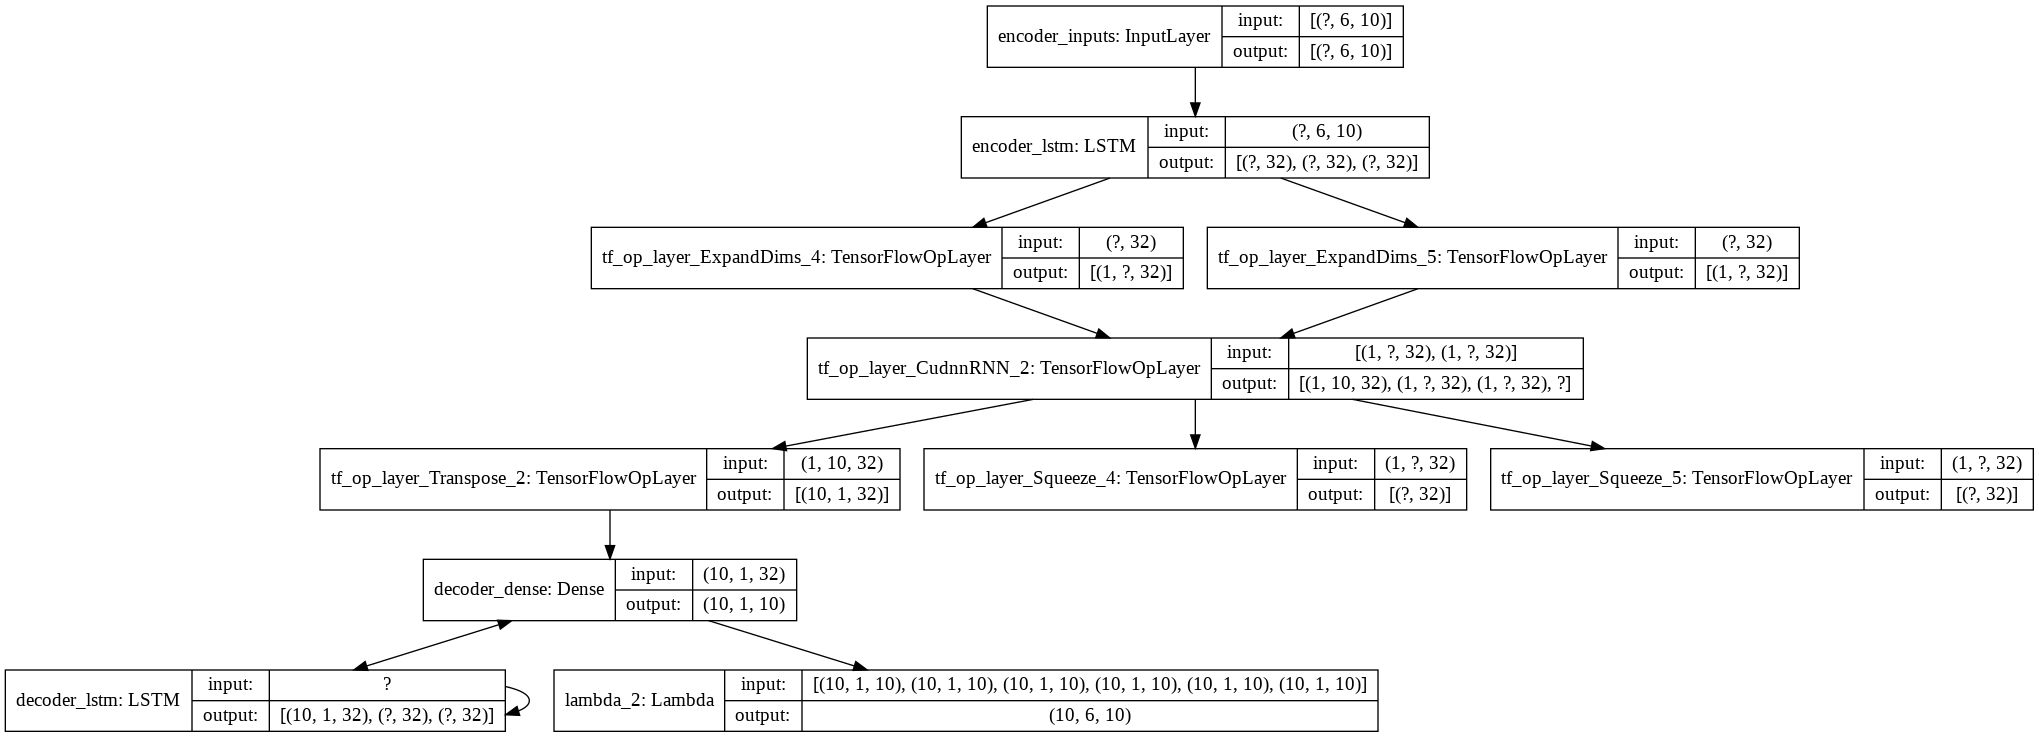

time: 1.36 s


In [ ]:
batch_size = 10
model_encoder_decoder=create_hard_coded_decoder_input_model(batch_size=batch_size)
model_encoder_decoder.summary()
plot_model(model_encoder_decoder, show_shapes=True)

# Train model 
```python
model_encoder_decoder.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=30,
          validation_split=0.2)
```

training for  500  epochs begins with EarlyStopping(monitor= val_loss, patience= 10 )....
Epoch 1/500
360/360 [==============================] - 4s 10ms/step - loss: 0.2217 - accuracy: 0.2349 - val_loss: 0.1880 - val_accuracy: 0.2617
Epoch 2/500
360/360 [==============================] - 4s 10ms/step - loss: 0.1938 - accuracy: 0.2557 - val_loss: 0.1620 - val_accuracy: 0.2779
Epoch 3/500
360/360 [==============================] - 4s 10ms/step - loss: 0.1684 - accuracy: 0.2697 - val_loss: 0.1382 - val_accuracy: 0.2888
Epoch 4/500
360/360 [==============================] - 4s 10ms/step - loss: 0.1426 - accuracy: 0.2818 - val_loss: 0.1148 - val_accuracy: 0.2983
Epoch 5/500
360/360 [==============================] - 4s 10ms/step - loss: 0.1154 - accuracy: 0.2935 - val_loss: 0.0872 - val_accuracy: 0.3050
Epoch 6/500
360/360 [==============================] - 4s 10ms/step - loss: 0.0902 - accuracy: 0.3050 - val_loss: 0.0691 - val_accuracy: 0.3162
Epoch 7/500
360/360 [=========================

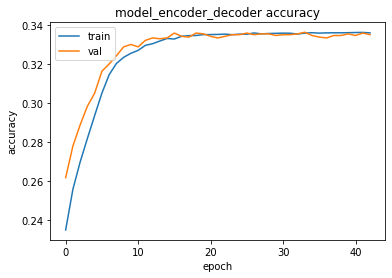

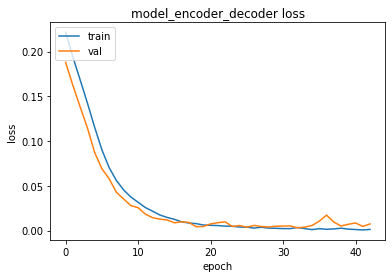

10 examples from test data...
Input                Expected             Predicted               T/F
[9, 5, 4, 0, 0, 0]   [4, 0, 0, 0, 0, 0]   [4, 4, 2, 4, 4, 2]   False
[1, 9, 2, 1, 0, 0]   [2, 0, 0, 0, 0, 0]   [2, 4, 4, 2, 4, 2]   False
[3, 3, 7, 7, 1, 0]   [0, 0, 0, 0, 0, 0]   [4, 2, 4, 2, 4, 2]   False
[6, 5, 8, 0, 0, 0]   [8, 6, 0, 0, 0, 0]   [8, 6, 6, 2, 6, 8]   False
[8, 9, 9, 0, 0, 0]   [8, 0, 0, 0, 0, 0]   [8, 2, 4, 8, 4, 4]   False
[3, 5, 6, 7, 3, 0]   [6, 0, 0, 0, 0, 0]   [6, 4, 4, 6, 2, 4]   False
[4, 3, 1, 9, 0, 0]   [4, 0, 0, 0, 0, 0]   [4, 2, 4, 4, 4, 4]   False
[7, 5, 2, 0, 0, 0]   [2, 0, 0, 0, 0, 0]   [2, 4, 4, 2, 2, 2]   False
[2, 8, 7, 0, 0, 0]   [8, 2, 0, 0, 0, 0]   [8, 2, 4, 2, 2, 4]   False
[4, 2, 5, 2, 1, 1]   [2, 2, 4, 0, 0, 0]   [2, 2, 4, 4, 2, 4]   False
Accuracy:  0.0
time: 2min 42s


In [ ]:
trained_model=train_test(model_encoder_decoder, X_train_padded, y_train_padded ,
           X_test_padded, 	y_test_padded, batch_size=batch_size,epochs=500, patience= 10, verbose=1)

# OBSERVATIONS
* We created an encoder decoder model for a **variable** size input/output sequences
* Encoder consumes all the input sequence at once and creates a context vector
* Decoder use the context vector created by the encoder and a special sign 'start' to output the first token in the output sequence
* Decoder works in a loop
* Each cycle of the loop, Decoder output a token in the output sequence
* To create the current output, decoder use its last output and state as input and context vector to itself
* When the fixed size output tokens are created decoder stops

# Do it yourself:
* You can observe the effects of changing the numbers of
** LSTM units 
** LSTM layer 
** Sequence length

* You can use multiple LSTM layers in encoder and/or decoder


In the next part we will modify the encoder decoder model such that it will handle variable size input/output sequences

# PART F: ENCODER-DECODER ARCHITECTURE/MODEL TO HANDLE VARIABLE SIZE INPUT/OUTPUT WITH TEACHER FORCING